In [ ]:
from Capsule.CapsuleLayer import CapsuleRouting
import torch
routing = CapsuleRouting(mode='em')

v = torch.rand(2, 8, 10, 16, 1, 1)
a = torch.rand(2, 8, 1, 1)
v, a = routing(v, a)
print(a)

In [ ]:
from Capsule.CapsuleLayer import AdaptiveCapsuleHead
import torch

model = AdaptiveCapsuleHead(32, 10, 4, 1, False, *["dynamic", 10, 1.5])
v = torch.rand(2, 32, 5, 5)

out, v = model(v, get_capsules=True)
print(v.shape)
print(v)

In [ ]:
import yaml
import torch
from Capsule.Layer.Classifier import CapsuleWrappingClassifier
with open('config/new-config.yml', 'r') as stream:
    PARAMS = yaml.safe_load(stream)
    print(PARAMS)
model = CapsuleWrappingClassifier(model_configs=PARAMS['architect_settings'])

img = torch.rand(2, 3, 224, 224)

out = model(img)
print(out.shape)
print(out)

In [ ]:
from Capsule.ultis import Cub2011
from matplotlib import pyplot as plt
from torchvision.transforms import ToPILImage
dataset = Cub2011(mode='test', data_path='data/CUB_200_2011', transform=None)

img, label, oimg = dataset[10]
print(label)
plt.imshow(ToPILImage()(oimg))
plt.show()

In [ ]:
import numpy as np
a = np.arange(60.).reshape(3,4,5)
b = np.arange(24.).reshape(4,3,2)
print(a)
print(b)
np.einsum('ijk,jil->kl', a, b)

In [ ]:
import torch
A = torch.rand(2, 15, 4, 4, 3, 3)
B = torch.rand(15, 4, 4, 8)
v = torch.einsum('bBijHW, BjkC -> bBCikHW', A, B)
print(v.shape)

## Linear Classifier

In [ ]:
PARAMS =  {
    "architect_settings" : {
            "task": "None",
            "name": "model-test",
            "backbone": {
                    "name": "resnet-s",
                    "is_full": False,
                    "is_pretrained": True,
                    "is_feats": False,
                    "is_freeze": True, 
            },
            "n_cls": 2,
            "is_caps": False,
            "caps":{
                "mode": 1,
                "cap_dims": 4,
                "routing":{
                        "type": "dynamic",
                        "params": [3, 0.01, 1.5]
                    }
                }
            },
    "dataset_settings": {
            
            },
    "training_settings":{
    
    }
}

from Capsule.Layer.Classifier import CapsuleWrappingClassifier
from Capsule.ultis import Cub2011, CIFAR10read
from torch.utils.data import DataLoader
import torch.nn.functional as F
import h5py
import numpy as np

model = CapsuleWrappingClassifier(model_configs=PARAMS["architect_settings"])
model.eval()

def get_train_data(model, dataloder):
    train_data = []
    train_label = []    
    for batch in dataloder:
        img, label, oimg = batch
        feats = model.backbone(img)
        out = feats.reshape(-1, 512, 7, 7)
        train_data.append(out.detach().numpy())
        train_label.append(label.detach().numpy())

    train_data = np.concatenate(train_data, axis=0)
    train_label = np.concatenate(train_label, axis=0)
    print(train_data.shape)
    print(train_label.shape)
    return train_data, train_label
    

In [ ]:
dataset = CIFAR10read(mode="train", data_path="data")
dataloder = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=4)

train_data, train_label = get_train_data(model, dataloder)

hf = h5py.File('data/CIFAR10_train_data.h5', 'w')
hf.create_dataset('data', data=train_data)
hf.create_dataset('label', data=train_label)
hf.close()

In [ ]:
dataset = CIFAR10read(mode="test", data_path="data")
dataloder = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=4)

test_data, test_label = get_train_data(model, dataloder)

hf = h5py.File('data/CIFAR10_test_data.h5', 'w')
hf.create_dataset('data', data=test_data)
hf.create_dataset('label', data=test_label)
hf.close()

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import h5py

hf = h5py.File('data/CIFAR10_train_data.h5', 'r')
train_data = np.array(hf['data'])
train_label = np.array(hf['label'])
hf.close()
hf = h5py.File('data/CIFAR10_test_data.h5', 'r')
test_data = np.array(hf['data'])
test_label = np.array(hf['label'])
hf.close()

train_data = np.mean(train_data, axis=(2, 3))
test_data = np.mean(test_data, axis=(2, 3))

#scikit-learn MLPClassifier on train_data, train_label
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=(512, 512), max_iter=1000)
clf.fit(train_data, train_label)
accuracy_score(clf.predict(test_data), test_label)

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

clf = SVC(kernel='rbf')
clf.fit(train_data, train_label)
accuracy_score(clf.predict(train_data), train_label)
accuracy_score(clf.predict(test_data), test_label)

In [ ]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch
import h5py
import numpy as np

hf = h5py.File('data/CUB_ResNet_train_data.h5', 'r')
train_data = np.array(hf['data'])
train_label = np.array(hf['label'])
hf.close()

tensor_x = torch.Tensor(train_data) # transform to torch tensor
tensor_y = torch.Tensor(train_label)
my_dataset = TensorDataset(tensor_x,tensor_y)
train_loader = DataLoader(my_dataset, batch_size=32, shuffle=True)

In [ ]:
hf = h5py.File('data/CUB_ResNet_test_data.h5', 'r')
test_data = np.array(hf['data'])
test_label = np.array(hf['label'])
hf.close()

tensor_x = torch.Tensor(test_data) # transform to torch tensor
tensor_y = torch.Tensor(test_label)
my_val_dataset = TensorDataset(tensor_x,tensor_y)
valid_loader = DataLoader(my_val_dataset, batch_size=32, shuffle=True)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from Capsule.CapsuleLayer import AdaptiveCapsuleHead

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(device)

classifier = nn.Sequential(
                AdaptiveCapsuleHead(512, 200,
                4, 4, True, 
                *['dynamic', 3, 2]),
                # nn.LogSoftmax(dim=1),
                nn.Flatten(start_dim=1)
            )

# Define the classifier on top of the ResNet
# classifier = nn.Sequential(
#     nn.Linear(512, 512, 1),
#     nn.ReLU(),
#     nn.Linear(512, 512, 1),
#     # nn.LogSoftmax(dim=1),
#     # nn.Flatten(start_dim=1)
# )

# # Combine the ResNet and classifier
# from torchvision.models import resnet18
# resnet = resnet18(pretrained=True)
# resnet.fc = nn.Identity()
# model = nn.Sequential(resnet, classifier)
model = classifier.to(device)
# Load the MNIST dataset
# train_dataset = Cub2011(mode="train", data_path="data/CUB_200_2011")
# valid_dataset = Cub2011(mode="val", data_path="data/CUB_200_2011")

# # Set hyperparameters
batch_size = 64
learning_rate = 0.0001
num_epochs = 100

# # Create data loaders
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

max_val = 0
# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    train_correct = 0
    total_train_samples = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/ {num_epochs} - Training"):
        
        images = images.to(device)
        labels = labels.to(device).long()
        # print(images, labels)
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Compute training accuracy
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == labels).sum().item()
        total_train_samples += labels.size(0)

        train_loss += loss.item()

    # Compute average training accuracy and loss
    train_accuracy = 100.0 * train_correct / total_train_samples
    train_loss /= len(train_loader)

    # Validation phase
    model.eval()
    valid_loss = 0.0
    valid_correct = 0
    total_valid_samples = 0

    with torch.no_grad():
        for images, labels in tqdm(valid_loader, desc=f"Epoch {epoch + 1}/ {num_epochs} - Validation"):
            # Forward pass
            images = images.to(device)
            labels = labels.to(device).long()
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Compute validation accuracy
            _, predicted = torch.max(outputs.data, 1)
            valid_correct += (predicted == labels).sum().item()
            total_valid_samples += labels.size(0)

            valid_loss += loss.item()

    # Compute average validation accuracy and loss
    valid_accuracy = 100.0 * valid_correct / total_valid_samples
    valid_loss /= len(valid_loader)
    if(valid_accuracy > max_val):
        max_val = valid_accuracy
    # Print epoch-wise results
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.2f}%")
    print(f"Valid Loss: {valid_loss:.4f} | Valid Accuracy: {valid_accuracy:.2f}%")
print(f"Max Valid Accuracy: {max_val:.2f}%")

CUB
- CUB-resnet-sci-SVM: 0.5904
- CUB-resnet-freeze-2hMLP: 0.5856
- CUB-resnet-sci-MLP: 0.577

CIFAR
- CIFAR-resnet-sci-MLP: 0.8717
- CIFAR-resnet-sci-SVM: 0.8822

In [ ]:
from Capsule.CapsuleLayer import CapsuleRouting
import torch
p = torch.randn(2, 32, 16, 4, 4)
a = torch.randn(2, 32, 4, 4)
params = {"reduce": True,
        "cap_dims": 4,
        "routing":{
                "type": "em",
                "iters": 3,
                "temp": 1.5,
        }
}

dynamic_routing = CapsuleRouting(B=32, C=10, caps=params)
dynamic_routing.eval()
v_out, a_out = dynamic_routing(p, a)
print(v_out.shape, a_out.shape)
print(a_out, v_out)
# print(dynamic_routing.W_ij)

In [ ]:
from Capsule.CapsuleLayer import AdaptiveCapsuleHead
import torch
p = torch.randn(2, 512, 7, 7)
# a = torch.randn(2, 512, 7, 7)
params = {
    "n_cls": 10,
    "n_layers": 2,
    "n_emb": 512,
    "is_caps": False,
    "caps": {
        "pooling": "None",
        "shuffle": True,
        "cap_style": "c", # c: by channel, hw: by height and width
        "cap_dims": 4,
        "routing":{
            "reduce": True,
            "type": "dynamic",
            "iters": 3,
            "temp": 1.5,
        }
    }
}
adaptive_capsule_head = AdaptiveCapsuleHead(512, head=params)
adaptive_capsule_head.eval()
a_out = adaptive_capsule_head(p)
print(a_out.shape)
print(a_out)

In [ ]:
from Capsule.CapsuleLayer import ProjectionHead
import torch
p = torch.randn(2, 512, 7, 7)

projection_head = ProjectionHead(512, 32, 1)
print(projection_head)
out = projection_head(p)
print(out.shape)
print(out)

In [ ]:
class AdaptivePoolCapsuleHead(nn.Module):
    '''
    Capsule Header combines of Primary Capsule and Linear Capsule.
    
    - Arguments:
        B: number of capsule in L layer
        C: number of capsule in L + 1 layer
        get_capsules: Return Capsules's vector
        P: size of a capsule
        reduce: reduce the featrue maps before routing
        args: arguments for routing method
        argv[0]: routing method
        argv[1]: number of iteration
        argv[2]: m for fuzzy routing
    '''
    def __init__(self, B, head):
        super(AdaptivePoolCapsuleHead, self).__init__()
     
  
        self.reduce = head['caps']['reduce']
        self.n_layers = head['n_layers']
        n_emb = head['n_emb']
        self.P = head['caps']['cap_dims']

        assert B % (self.P * self.P) == 0, "channel is not divisible by P * P"
        self.B = B // (self.P * self.P)
        assert n_emb % (self.P * self.P) == 0, "embedding is not divisible by P * P"
        self.n_emb = n_emb // (self.P * self.P)
      
        self.primary_capsule = nn.Sequential()
        self.a_routing = nn.Sequential()
        if(self.reduce):
            self.primary_capsule.append(nn.AdaptiveAvgPool2d((1, 1)))
            self.a_routing.append(nn.AdaptiveAvgPool2d((1, 1)))
        if(self.n_layers == 1):
            self.primary_capsule.append(nn.Identity())
            self.routinglayer = CapsuleRouting(self.B, head['n_cls'], head['caps'])
        else:
            self.primary_capsule.append(nn.Conv2d(B, n_emb, 1))
            self.primary_capsule.append(nn.ReLU())
            for i in range(1, self.n_layers - 1):
                self.primary_capsule.append(nn.Conv2d(n_emb, n_emb, 1))
                if(i < self.n_layers - 1):
                    self.primary_capsule.append(nn.ReLU())
            self.routinglayer = CapsuleRouting(self.n_emb, head['n_cls'], head['caps'])

        self.a_routing.append(nn.Conv2d(B, self.B, 1))

    def forward(self, x, get_capsules=False):
        '''
        input: 
            tensor 4D (b, B, h, w)
        output:
            capsule 3D (b, C, P*P) / 5D (b, C, P*P, h, w)
            activation 2D (b, C) / 5D (b, C, h, w)
        '''
        # Primary capsule
        
        # p <- (b, B, P * P, h, w)
        # a <- (b, B, h, w)
        p = self.primary_capsule(x)
        # x <- (b, C, h, w)
        b, d, h, w =  p.shape
        p = p.reshape(b, self.B , self.P ** 2, h, w)
       
        a = self.a_routing(x)
        a = torch.sigmoid(a)
        
        print(p.shape, a.shape)
        p_out, a_out = self.routinglayer(p, a)
        a_out = torch.log(a_out / (1 - a_out + EPS))
       
        if get_capsules:
            return p_out, a_out
        else: 
            return a_out

In [ ]:
import torch.nn as nn

orthogonal_weight = torch.nn.utils.parametrizations.orthogonal(nn.Conv2d(2, 2, 3))
print(orthogonal_weight.weight[0][0].T @ orthogonal_weight.weight[0][0])

In [ ]:
from Capsule.model import CapsuleWrappingClassifier, CapsuleWrappingSegment
import yaml
with open('config/new-config.yml', 'r') as stream:
        PARAMS = yaml.safe_load(stream)
        print(PARAMS)

model = CapsuleWrappingSegment(PARAMS['architect_settings'])

import torch
x = torch.randn(2, 3, 224, 224)
out = model(x)
# print(model)
print(out)

In [ ]:
from Capsule.ultis import CIFAR100read

dataset = CIFAR100read(mode='train', data_path='data')

print(dataset[0][0].shape, dataset[0][1])

In [ ]:
from torchvision.datasets import Caltech101
dataset = Caltech101(root='data', download=True)
dataset[6999][0]
# print(dataset[0][0].shape, dataset[0][1])

In [ ]:
from Capsule.ultis import Caltech101read
from torchvision.transforms import ToPILImage
dataset = Caltech101read(mode='train', data_path='data')
ToPILImage()(dataset[1000][2])

In [5]:
from torchvision.datasets import VOCSegmentation
dataset = VOCSegmentation(root='data', download=False, image_set='train', transforms=None)
len(dataset)

1464

In [7]:
from torchvision.datasets import VOCSegmentation
import numpy as np
dataset = VOCSegmentation(root='data', download=False, image_set='val', transforms=None)
len(dataset)
# dataset[10][1]


1449

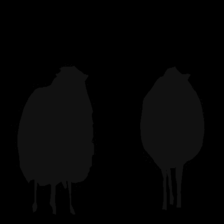

In [4]:
from Capsule.ultis import VOC2012read
from torchvision.transforms import ToPILImage

# import albumentations as A
import cv2

# transform = A.Compose([
#     A.RandomCrop(width=256, height=256),
#     A.HorizontalFlip(p=0.5),
#     A.RandomBrightnessContrast(p=0.2),
# ])

dataset = VOC2012read(mode='val', data_path='data')
ToPILImage()(dataset[30][1])


In [19]:
import torch
from torch import nn

B = 8
C = 10
P = 16

W_ij = nn.Conv3d(1, C * P, kernel_size=(P, 1, 1), stride=(P, 1, 1), bias=False)
x = torch.randn(2, B, P, 4, 4)
pre_votes = [W_ij(x_sub) for x_sub in torch.split(x, 1, dim=1)]
out = torch.concat([pre_vote.reshape(2, 1, C, P, 4, 4) for pre_vote in pre_votes], dim=1)
# out = out.reshape(2, C, P, 4, 4)
print(out.shape)

torch.Size([2, 8, 10, 16, 4, 4])


In [16]:

# torch split channel
x = torch.randn(2, 8, 16, 4, 4)
x = torch.split(x, 1, dim=1)
print(len(x), x[0].shape)

8 torch.Size([2, 1, 16, 4, 4])


In [4]:
from Capsule.Routing import CapsuleRouting
import torch
routing = {
            "type": "dynamic",
            "iters": 3,
            "temp": 1.5,
        }
routinglayer = CapsuleRouting(B=8, C=10, P=4, cap_style='c', routing=routing)
x = torch.randn(2, 8, 16, 4, 4)
a = torch.randn(2, 8, 4, 4)
out, a_out = routinglayer(x, a)
print(out.shape, a_out.shape)

torch.Size([8, 10, 16, 4, 4]) torch.Size([8, 10, 4, 4])


In [5]:
print(a_out)

tensor([[[[0.6040, 0.2777, 0.5767, 0.6165],
          [0.3758, 0.6596, 0.2936, 0.4022],
          [0.1371, 0.2124, 0.1872, 0.5220],
          [0.6030, 0.9207, 0.6121, 0.3350]],

         [[0.2275, 0.1710, 0.1875, 0.3032],
          [0.5928, 0.1790, 0.5142, 0.3214],
          [0.1956, 0.1329, 0.1470, 0.2669],
          [0.3955, 0.3904, 0.2644, 0.3318]],

         [[0.9401, 0.4373, 0.1585, 0.4811],
          [0.8968, 0.3519, 0.5971, 0.4272],
          [0.2898, 0.7556, 0.5593, 0.8210],
          [0.4495, 0.6246, 0.9292, 0.8334]],

         ...,

         [[0.0599, 0.1059, 0.1413, 0.3700],
          [0.1051, 0.1277, 0.1526, 0.0729],
          [0.0581, 0.2813, 0.3703, 0.1075],
          [0.0943, 0.0784, 0.2443, 0.1532]],

         [[0.0724, 0.5346, 0.3136, 0.1972],
          [0.3040, 0.0528, 0.3302, 0.3278],
          [0.6266, 0.2282, 0.1380, 0.0495],
          [0.4101, 0.0880, 0.1419, 0.2759]],

         [[0.2673, 0.0852, 0.5434, 0.4361],
          [0.6748, 0.3486, 0.3713, 0.1408],
       

In [26]:
# inference on CIFAR10 dataset with ResNet18
import torch
from torch import nn
from torchvision import models
from torchvision import transforms
from torch.utils.data import DataLoader
from Capsule.ultis import CIFAR10read, Caltech101read, CIFAR100read
import numpy as np

dataset = CIFAR100read(mode='train', data_path='data')
model = models.resnet18(pretrained=True).cuda()
model.avgpool = nn.Identity()
model.fc = nn.Identity()
model.eval()

dataloader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=0)
train_list = []
train_label = []

for i, (x, y, image) in enumerate(dataloader):
    out = model(x.cuda())
    out = out.reshape(out.shape[0], -1, 7, 7)
    train_list.append(out.cpu().detach().numpy())
    train_label.append(y.numpy())

train_list = np.concatenate(train_list, axis=0)
train_label = np.concatenate(train_label, axis=0)
print(train_list.shape)
# save train_list and train_label to h5 file


Files already downloaded and verified
(40000, 512, 7, 7)


In [27]:
import h5py
with h5py.File('data/CIFAR100-features/cifar100_train.h5', 'w') as f:
    f.create_dataset('data', data=train_list)
    f.create_dataset('label', data=train_label)
    f.close()

In [28]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import h5py

hf = h5py.File('data/CIFAR100-features/cifar100_train.h5', 'r')
train_data = np.array(hf['data'])
train_label = np.array(hf['label'])
hf.close()
hf = h5py.File('data/CIFAR100-features/cifar100_val.h5', 'r')
test_data = np.array(hf['data'])
test_label = np.array(hf['label'])
hf.close()

train_data = np.mean(train_data, axis=(2, 3))
test_data = np.mean(test_data, axis=(2, 3))

#scikit-learn MLPClassifier on train_data, train_label
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=(512, 512), max_iter=1000)
clf.fit(train_data, train_label)
accuracy_score(clf.predict(test_data), test_label)

0.6414

In [29]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

clf = SVC(kernel='rbf')
clf.fit(train_data, train_label)
accuracy_score(clf.predict(train_data), train_label)
accuracy_score(clf.predict(test_data), test_label)